# Buy or Rent

## Plot 

Buying a real estate property is, probably, one of the most important decisions a family needs to settle. Indeed, on the one hand, quite often the price of a residence has the lion's share in the entire lifetime budget of a family. On the other hand, mortgage payments prolong for up to 30 years, overlapping a significant part of people lives. Quite obviously, the right decision in locking a reasonable price for a house with a good interest rate can positively influence somebody's life. By the same reasons, someone's life can be ruined by hastily made real-estate decisions.

Of course, it seems impossible to construct a comprehensive model capable of predicting real estate prices for 30+ years. Practically, however, such a model is not needed, because a decision for purchasing a noninvestment property is usually driven not by economic reasons. A family needs some place to live. Although renting is an option, it is often a relatively short term solution, leading to eventual homeownership. 

Therefore here I try to answer the following question:
* **If I am renting an apartment now, when should I buy a house to minimize my costs?**

To make this task manageable, I consider the following constraints:
* I plan to buy a house in the next 5-6 years
* I consider the real-estate market of Eastern Massachusetts
* I am relatively flexible with the location of the house


## Machine learning formulation

The total cost of homeownership consists of the price of a house plus rent I have to pay before the purchase. There are also a ton of other expenses, like legal fees, mortgage interest, repairs, etc., but in this analysis, we neglect them.

![house costs](img/house_cost.png)

The figure above illustrates the house cost break down. A naive answer for the central question in this research may be buying a house at this given moment, because the rent accumulates, and eventually leads to losing money.

However, house prices may fluctuate significantly. A recent fluctuation happened during the 2007-2008 housing bubble burst. In the case of a significant market collapse, the house prices may drop, adjusting the cost of renting.

Sure, I am not going to predict if the next housing burst is waiting how dramatic it could be, but it is not our goal. Looking back into the time of the previous market burst, we can study the evolution of the macroeconomic factor during this event. Quite possibly, the next crisis will replicate at least in some detail the behavior of the previous one, so we have some estimation how economics may behave. 

However, macroeconomic indicators are not very useful for understanding the price for the particular house type in a particular location. But the macroeconomic factors can be used as "defining trends," by which I can estimate the prices on a particular local market. 

Above said, I reformulate my business question into a machine learning question:
* **Predict prices of a unit with a particular number of bedrooms and located in a particular area (targets) based on macroeconomic factors (features)**


## Data

All data is stored in `/data` folder with minimal preprocessing.

Listing and Rental prices datasets used:

1. The median listing and rent prices by zip code, county, and state for 2011-2018 (no data for the time when markets collapsed in 2007-2008) ("Zillow dataset") [https://www.kaggle.com/zillow/zecon]. CSV format. The dataset was gzipped save space.

1. House price index (HPI, 2001-2019). Aggregated government data at a large region level (i.e. New England). [https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index.aspx]. CSV format.

1. Fair Market Rent (FMR, 2001-2019). Annual data for rental rates at the county or town level. [https://www.huduser.gov/portal/datasets/fmr.html]. Poorly structured Excel files with a slightly different format for each year. Combined and stored as a single mp file. A conversion script is provided. 

Axillary datasets:

1. 30 year fixed historical mortgage APR [https://fred.stlouisfed.org/series/MORTGAGE30US]

1. NCHS Urban-Rural Classification Scheme for Counties [https://www.cdc.gov/nchs/data_access/urban_rural.htm]



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ipywidgets as widgets

from IPython.display import display
from pandas.plotting import register_matplotlib_converters
from sklearn.linear_model import LinearRegression

register_matplotlib_converters()

# Import helper scripts for data loading

from model.helper import (
    load_houseprices_by_urban_codes,
    load_loan_apr_monthly,
    load_hpi_master,
    load_fmr_by_region
)

In [2]:
%load_ext autoreload
%autoreload 2

### Load features into notebook for visualization

In [3]:
apr = load_loan_apr_monthly()
hpi_ma = load_hpi_master('New England Division')
house_prices, selected_counties = load_houseprices_by_urban_codes(state="MA")
fmr = load_fmr_by_region(selected_counties)
fmr = fmr[fmr.Date.dt.year<2018]

#### Combine all features in one DataFrame

In [4]:
features = apr.merge(hpi_ma[['Date', 'hpi_sa']], on='Date').merge(fmr, on='Date') 
features.head()

,Date,apr,hpi_sa,fmr
0,2002-12-31,0.060475,180.47,1247.227827
1,2003-01-31,0.059160,182.35,1252.561653
2,2003-02-28,0.058425,183.11,1257.895479
3,2003-03-31,0.057450,184.04,1263.229305
4,2003-04-30,0.058125,186.45,1268.563130


#### Let's exampine FMR and HPI graphically

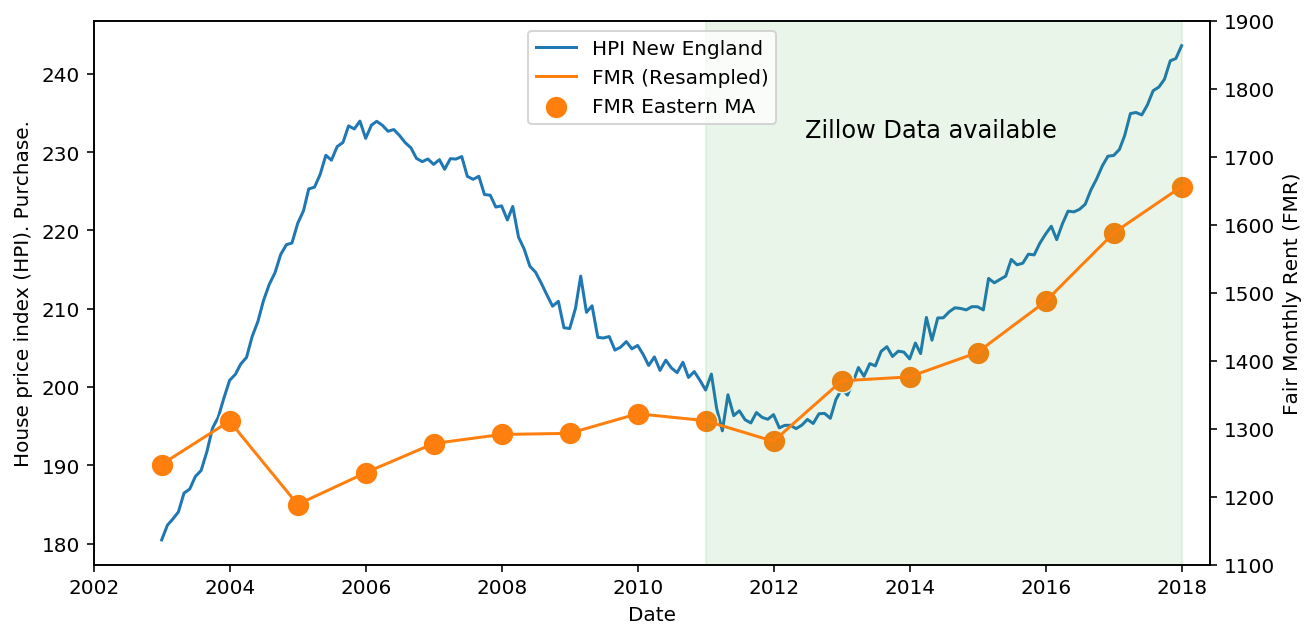

In [5]:
plt.figure(figsize=(10,5))
sns.lineplot(data=features, x='Date', y='hpi_sa', label='HPI New England', legend=False)
plt.ylabel('House price index (HPI). Purchase.')

ax1 = plt.gca()
ax2 = ax1.twinx()
sns.scatterplot(ax = ax2, data=features[::12], x='Date', y='fmr', label='FMR Eastern MA', color='C1', s=130, legend=False)
sns.lineplot(data=features[::], x='Date', y='fmr', label='FMR (Resampled)', color='C1', legend=False)
ax2.set_ylim(1100, 1900)
ax2.set_ylabel('Fair Monthly Rent (FMR)')

plt.text(0.75, 0.8,'Zillow Data available',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes,
     fontsize=12)

plt.axvspan(pd.to_datetime('2011-01-01'), pd.to_datetime('2018-01-01'), alpha=0.1, color='C2')

plt.xlim(datetime.date(2002, 1,1), datetime.date(2018, 6,1))

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=9);


#### Observations:

1. Before the housing bubble burst, HPI was rising very fast.
1. In contrast, the rent rates ware not rasing significantly, and the FMR even dropped before the burst.
1. After the burst HPI decreases significantly during the correction.
1. Again, FMR stays practically at the same level and picks up growth after the HPI starts.
1. The local house market data is only available during the growth period.
1. HPI data is quite noisy, and we need to smoothen it.
1. FMR is reported only annually, so we use linear interpolation.

### Targets: house prices from Zillow

We divide Eastern Massachusetts into three areas based on the lifestyle: rural, suburb, and urban. We use the county-level Zillow dataset and the NCHS Urban-Rural Classification Scheme and calculate the average of the listing and rental prices in counties having the same classification.

Zillow dataset reports prices for units having a different number of bedrooms. This quantity defines the size of a dwelling. In our model, we consider houses having rooms from 1 to 4. The dataset also reports prices for smaller studios and larger 5+ bedroom houses, but this data is sparse.

A combination of the area density (rural, suburb, urban) and the number of bedrooms defines **a market**. For each market we build a machine learning (linear regression) model.

In [71]:
# Load python classes implementing the machine learling models
# to avoid some heavylifting in data importing and processing

from model.price_model import PriceModel
from model.rent_model import RentModel
pm = PriceModel()
rm = RentModel()

list_prices = pm.features_and_targets[['Date', 'rooms', 'density', 'target']]
rent_prices = rm.features_and_targets[['Date', 'rooms', 'density', 'target']]

Let's look at the listing prices and rent rates for three-bedroom houses located in different areas.

Try to operate the dropdown control to overview different markets

In [72]:
def plot_listing_rental(rooms):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.scatterplot(data=list_prices[list_prices.rooms==rooms], x='Date', y='target', hue='density', lw=2, 
                    hue_order=['urban', 'suburb', 'rural'])
    plt.xlim(datetime.date(2011, 1,1), datetime.date(2018, 1,1))
    plt.title(f'Listing bedrooms={rooms}')
    plt.ylabel('Listing Price, k$')

    plt.subplot(122)
    sns.scatterplot(data=rent_prices[rent_prices.rooms==rooms], x='Date', y='target', hue='density', lw=2, 
                    hue_order=['urban', 'suburb', 'rural'])
    plt.xlim(datetime.date(2011, 1,1), datetime.date(2018, 1,1))
    plt.title(f'Rental bedrooms={rooms}')
    plt.ylabel('Rental rate, $/month')

    plt.tight_layout()
    

def dropdown_rooms_handler(change):
    output.clear_output()
    with output:
        plot_listing_rental(change.new)
        plt.show()

dropdown_rooms = widgets.Dropdown(options=(range(1,5)), value=3, description='Rooms: ')
dropdown_rooms.observe(dropdown_rooms_handler, names='value')

output = widgets.Output() 


display(dropdown_rooms)
display(output)

with output:
    plot_listing_rental(3)
    plt.show()

output.layout.height = '350px'
# plot_listing_rental(4)

Dropdown(description='Rooms: ', index=2, options=(1, 2, 3, 4), value=3)

Output()

### Observations:

1. The trends well correlate with the macro-indecies (FMR and HPI)
1. The prices experience seasonal periodicity, which must be catched


### Feature engineering: Periodicity

To model the seasonal periodic behavior we can use harmonic functions. We can represent the periodic part $P_p$ of the price as:

$$P_p = \sum_{n=1}^N \gamma^s_{n} \sin\left(\dfrac{2\pi\times n\times \mathrm{month}}{12}\right) + \gamma^c_{n}\cos\left(\dfrac{2\pi\times n\times \mathrm{month}}{12}\right)$$

Here $N$ defines the number of harmonics we take in this expansion, i.e. $N=1$ means annual periodicity, $N=2$ means semi-annual, and so on. The number of harmonics $N$ will serve as a hyper-parameter of our model.

### Data processing: Smoothing

The time-series data for FMR and APR is noisy due to random fluctuations and sampling errors. But we know that the real estate markets are inertial and rapid changes are unlikely. Therefore it is undesirable to filter out fluctuations or noise from propagating into the model.

To achieve noise filtering, we employ [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) (savgol) which a standard approach in digital signal processing, experimental science, and market analysis.
   
Savgol is implemented in `scipy`, but `scikit-learn` does not provide a transformation class. I implemented a  savgol transformation class in `model/transformtaions.py`

Below there is an interactive illustration how savgol works, adjust handers for the window length and approxmation polynom order


In [8]:
from model.transformations import SavgolFilter

def plot_savgol(window, order):
    output_savgol.clear_output()
    with output_savgol:
        fig = plt.figure(figsize=(10,5))
        
        sns.scatterplot(x='Date', y='apr', data=apr, linewidth=0, alpha = 0.8, label='data')
        sns.lineplot(x='Date', y='apr_savgol', data= SavgolFilter('apr', window, order).transform(apr), lw=3, color='C1', label='fitered')
        
        plt.ylabel('APR')

        plt.legend()
        plt.show()

    
def slider_window_eventhandler(change):
    plot_savgol(window=change.new, order=slider_order.value)

def slider_order_eventhandler(change):
    plot_savgol(window=slider_window.value, order=change.new)
    
    
slider_order = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Order:', continuous_update=True)
slider_window = widgets.IntSlider(value=1, min=11, max=101, step=2, description='Window:')

display(slider_order)
display(slider_window)

slider_order.observe(slider_order_eventhandler, names='value')
slider_window.observe(slider_window_eventhandler, names='value')

output_savgol = widgets.Output()
output_savgol.layout.height = '300px'
display(output_savgol)

plot_savgol(11,1)

IntSlider(value=1, description='Order:', max=10, min=1)

IntSlider(value=11, description='Window:', max=101, min=11, step=2)

Output(layout=Layout(height='300px'))

### Complite Linear Regression model

For each of the local markets we build separate linear regression models for listing prices and rental rates.

Listing prices are approximated with the following model:

$$P^\text{price}_{r,u} = P^0_{r,u} + \alpha_{r,u} \mathrm{HPI} +  \beta^0_{r,u} \mathrm{APR} + \beta^1_{r,u} \dfrac{d\mathrm{APR}}{dt} +  \sum_{n=1}^N \gamma^{s, n}_{r,u} \sin\left(\dfrac{2\pi\times n \times \mathrm{month}}{12}\right) + \gamma^{c, n}_{r,u}\cos\left(\dfrac{2\pi\times n \times \mathrm{month}}{12}\right)$$
Here $r=[1,4]$ is the number of rooms and $u = [\text{'urban'}, \text{'suburb'}, \text{'rural'}]$ defined the location. 

We use a similar model for rental rates, but instead of the HPI we use the FMR index: 

$$P^\text{rent}_{r,u} = P^0_{r,u} + \alpha_{r,u} \mathrm{HPI} +  \beta^0_{r,u} \mathrm{APR} + \beta^1_{r,u} \dfrac{d\mathrm{APR}}{dt} +  \sum_{n=1}^N \gamma^{s,n}_{r,u} \sin\left(\dfrac{2\pi\times n\times \mathrm{month}}{12}\right) + \gamma^{c,n}_{r,u}\cos\left(\dfrac{2\pi\times n\times \mathrm{month}}{12}\right)$$


### **Let's us fit our models!**

In [73]:
pm.fit_all()
rm.fit_all()

In [74]:
price = pm.predict(features)
price = price.merge(pm.features_and_targets[['Date', 'rooms', 'urban_code', 'target', 'density']] , on=['Date', 'rooms', 'urban_code', 'density'], how='inner')

rent = rm.predict(features)
rent = rent.merge(rm.features_and_targets[['Date', 'rooms', 'urban_code', 'target', 'density']] , on=['Date', 'rooms', 'urban_code', 'density'], how='inner')

In [75]:
def plot_prediction(ax, model, result, r):
    ax = sns.lineplot(ax=ax, data=result[result.rooms==r], x='Date', y='y_hat', hue='density', 
                      legend=None, lw=2, hue_order=['urban', 'suburb', 'rural'])
    ax = sns.scatterplot(ax=ax, data=result[result.rooms==r], x='Date', y='target', hue='density', 
                         lw=2, hue_order=['urban', 'suburb', 'rural'])
    
    handles, labels = ax.get_legend_handles_labels()
    
    for u in range(1,4):
        r2 = model.models.loc[(model.models.rooms==r) & (model.models.urban_code==u) , 'model'].values[0].best_score_
        labels[u] += f' ($r^2$={r2:.2f})'
    ax.legend(handles, labels)
    
    

def plot_price_rent(r):
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot(121)
    plot_prediction(ax1, pm, price, r)
    ax1.set_ylabel('Listing price, k$')
    ax1.set_title(f'Listing price bedrooms={r}')
    ax2 = plt.subplot(122)
    plot_prediction(ax2, rm, rent, r)
    ax2.set_ylabel('Rental Rate, $/month')
    ax2.set_title(f'Rental rate bedrooms={r}')
    

def dropdown_mchk_rooms_handler(change):
    output_mchk.clear_output()
    with output_mchk:
        plot_price_rent(change.new)
        plt.show()

dropdown_mchk_rooms = widgets.Dropdown(options=(range(1,5)), value=3, description='Rooms: ')
dropdown_mchk_rooms.observe(dropdown_mchk_rooms_handler, names='value')

output_mchk = widgets.Output() 


display(dropdown_mchk_rooms)
display(output_mchk)

with output_mchk:
    plot_price_rent(3)
    plt.show()

# output_mchk.layout.height = '350px'


Dropdown(description='Rooms: ', index=2, options=(1, 2, 3, 4), value=3)

Output()

Let's us check metrics (cross-validated $r^2$ score) of all models here. The closer  $r^2$ to 1 - the better our model fits the data.

Here $r^2$ is calculated using KFold cross-validation, holding off 20% of random points for each validation. Also, $r^2$ is used to tune the hyper-parameters of the models and filter out insignificant features

In [21]:
def highlight_max(s):
    print(s)
    if s['r2 price'] < 0.5:
        return ['background-color: yellow']*len(s)


p_scores = pm.models.model.apply(lambda x: x.best_score_)
p_scores.name ='r2 price'
r_scores = rm.models.model.apply(lambda x: x.best_score_)
r_scores.name ='r2 rent'

cm = sns.light_palette("green", as_cmap=True)

pd.concat([pm.models[['rooms', 'density']], p_scores, r_scores], axis=1).style.background_gradient(
    cmap="Greens", subset=['r2 price', 'r2 rent'], low=0, high=1)


,rooms,density,r2 price,r2 rent
0,1,urban,0.96139,0.478348
1,1,suburb,0.945937,0.80798
2,1,rural,0.88528,0.550712
3,2,urban,0.954928,0.325835
4,2,suburb,0.930898,0.835827
5,2,rural,0.897287,0.329922
6,3,urban,0.949216,0.696226
7,3,suburb,0.918981,0.864501
8,3,rural,0.758903,-0.0800644
9,4,urban,0.92569,0.758384


We conclude that our models work very well in predicting listing prices, except for the rural area. The models for rental rates work worse, but still give a reasonably good fits for urban and suburb areas. 

### So the models work, let's predict the future

We model correction in the market as a drop in the HPI and FMR with subsequent recovery. We model correction in the market as a drop in the HPI and FMR with subsequent recovery. For each market, we compute the expected listing price and rental rates. Having that, we can calculate the total cost of a home, including paid rent. In our calculations, we consider that I am already renting starting on January 1, 2018


In [115]:
import scipy.interpolate as INT

def correction(x0, x1, x_c, y_c):
    x = np.asarray([x0, x0+1,  x_c, x1-1, x1])
    y = np.asarray([0,  0,    y_c,   0,0 ])
   
    sp = INT.CubicSpline(x,y, bc_type='clamped')

    return sp

years = 10

def rental_cost(df, t0, row):
    r = row.rooms
    uc = row.urban_code
    t =  row.Date
    
    dfur = df[(df.rooms==r) & (df.urban_code==uc)]
    acc = 0
    year = 12*pd.tseries.offsets.MonthEnd()
    while t0 < t:
        if (t - t0).days > 365:
            acc+=dfur.loc[dfur.Date==t0, 'y_hat'].values[0]*12
        else:
            acc+=dfur.loc[dfur.Date==t0, 'y_hat'].values[0]*(t - t0).days/30
        t0 += year
    return acc


def predict_future(corr):
    future = pd.DataFrame()

    future['Date'] = pd.Series(pd.date_range('2018-01-01', periods=12*years, freq='M', name='Date'))

    lm = LinearRegression()
    lm.fit(hpi_ma[hpi_ma.Date>'2016-01-01'][['Date']].astype(int), hpi_ma.loc[hpi_ma.Date>'2016-01-01', 'hpi_sa'])
    future['hpi_sa'] = lm.predict(future[['Date']].astype(int))
    future['hpi_sa'] += round((future.Date - future.Date[0]).dt.days/30).apply(correction(0, len(future),60, -corr))
    lm.fit(fmr[fmr.Date>'2012-01-01'][['Date']].astype(int), fmr.loc[fmr.Date>'2012-01-01', 'fmr'])
    future['fmr'] = lm.predict(future[['Date']].astype(int))
    future['fmr'] += round((future.Date - future.Date[0]).dt.days/30).apply(correction(0, len(future),60, -corr*8))
    lm.fit(apr[apr.Date>'2013-01-01'][['Date']].astype(int), apr.loc[apr.Date>'2013-01-01', 'apr'])
    future['apr'] = lm.predict(future[['Date']].astype(int))
    future = pd.concat([features, future],axis=0, sort=False).reset_index(drop=True)

    future_price = pm.predict(future)
    future_price = future_price.merge(pm.features_and_targets[['Date', 'rooms', 'urban_code', 'target']] , on=['Date', 'rooms', 'urban_code'], how='left')
    future_rent = rm.predict(future)
    future_rent = future_rent.merge(rm.features_and_targets[['Date', 'rooms', 'urban_code', 'target']] , on=['Date', 'rooms', 'urban_code'], how='left')
    
    return future, future_price, future_rent


def plot_result(ax, result, r, u):
    ax = sns.lineplot(ax=ax, data=result[(result.rooms==r) & (result.density==u)], x='Date', y='y_hat', 
                      legend=None, lw=2)
    ax = sns.scatterplot(ax=ax, data=result[(result.rooms==r) & (result.density==u)], x='Date', y='target', hue='density', 
                         lw=2)
    
def plot_price_rent_total(future, future_price, future_rent, r_price, u_price, r_rent, u_rent):
    plt.figure(figsize=(15,15))

    ax1 = plt.subplot(321)
    sns.lineplot(ax=ax1, data=future, x='Date', y='hpi_sa', legend=False)
    ax1.set_ylabel('House price index')
    
    ax2 = plt.subplot(322)
    sns.lineplot(ax=ax2, data=future, x='Date', y='fmr', legend=False)
    ax2.set_ylabel('Fair monthly rate')
    
    ax3 = plt.subplot(323)
    plot_result(ax3, future_price, r_price, u_price)
    ax3.set_ylabel('Prediced listing price, k$')
    
    ax4 = plt.subplot(324)
    plot_result(ax4, future_rent, r_rent, u_rent)
    ax4.set_ylabel('Prediced rental rate, $/month')
    
    ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    
    future_rent['total_rent_cost'] = future_rent[
        (future_rent.rooms==r_rent) & (future_rent.density==u_rent)].apply(
        lambda r: rental_cost(future_rent, pd.to_datetime('2018-01-31'), r), axis=1)/1000
    
    future_price = future_price[(future_price.rooms==r_price) & (future_price.density == u_price)]
    
    future_price = future_price.merge(
        future_rent[['Date', 'total_rent_cost']], on=['Date'], how='inner')
    
    future_price['total_cost'] = (future_price.y_hat + future_price.total_rent_cost)
    
    sns.lineplot(ax=ax5, data=future_price, x='Date', y='total_cost', legend=False, label='total cost')
    sns.lineplot(ax=ax5, data=future_price, x='Date', y='y_hat', legend=False, label='house price')
    sns.lineplot(ax=ax5, data=future_rent, x='Date', y='total_rent_cost', legend=False, label='rent cost')
    
    ax5.set_ylabel('Total cost, k$')
    
    today = pd.to_datetime('today')
    
    best_date = future_price.loc[future_price.loc[future_price.Date>today,'total_cost'].idxmin(), 'Date']
    
    
    ax5.axvline(best_date, c='C4', ls='-', lw=3, label='Best date to buy')
    ax5.axvline(today, c='k', ls='--', label='today')
    ax5.axvline(pd.to_datetime('2018-01-31'), c='C9', ls='--', label='started renting')
    
    ax5.legend()

    
    
    for ax in (ax1, ax2, ax3, ax4, ax5):
        ax.set_xlim(datetime.date(2015, 1,1), datetime.date(2026, 6,1))

        
        
def update_all(corr, r_price, u_price, r_rent, u_rent):
    output_all_pred.clear_output()
    with output_all_pred:
        future, future_price, future_rent = predict_future(corr)
        plot_price_rent_total(future, future_price, future_rent, r_price, u_price, r_rent, u_rent)
        plt.show()

state_all_pred = {
    'corr': 85,
    'r_price': 1,
    'u_price': 'urban',
    'r_rent': 1,
    'u_rent': 'urban',
}

def dropdown_r_density_update(change):
    state_all_pred['r_density'] = 'rural'
    update_all(**state_all_pred)


def slider_r_rooms_update(change):
    state_all_pred['r_rent'] = change.new
    update_all(**state_all_pred)

def sel_r_density_update(change):
    state_all_pred['u_rent'] = change.new
    output_all_pred.clear_output()
    update_all(**state_all_pred)

def slider_p_rooms_update(change):
    state_all_pred['r_price'] = change.new
    update_all(**state_all_pred)    
    

def sel_p_density_update(change):
    state_all_pred['u_price'] = change.new
    output_all_pred.clear_output()
    update_all(**state_all_pred)
    

def slider_corr_update(change):
    state_all_pred['corr'] = change.new
    update_all(**state_all_pred)


sel_r_density = widgets.RadioButtons(
    options=['urban', 'suburb', 'rural'],
    description='Density',
    disabled=False
)

sel_r_density.observe(sel_r_density_update, names='value')


sel_p_density = widgets.RadioButtons(
    options=['urban', 'suburb', 'rural'],
    description='Density',
    disabled=False
)

sel_p_density.observe(sel_p_density_update, names='value')

slider_r_rooms = widgets.IntSlider(value=1, min=1, max=4, step=1, description='Rooms:', continuous_update=False)
slider_r_rooms.observe(slider_r_rooms_update, names='value')

slider_p_rooms = widgets.IntSlider(value=1, min=1, max=4, step=1, description='Rooms:', continuous_update=False)
slider_p_rooms.observe(slider_p_rooms_update, names='value')


slider_corr = widgets.IntSlider(value=85, min=0, max=130, step=1, description='Correction:', continuous_update=False)
slider_corr.observe(slider_corr_update, names='value')

display(widgets.VBox([
    widgets.HBox([widgets.Label(value="I am renting"), sel_r_density, slider_r_rooms]),
    widgets.HBox([widgets.Label(value="I am going to buy"), sel_p_density, slider_p_rooms]),
    slider_corr
]))




# slider_window.observe(slider_window_eventhandler, names='value')

output_all_pred = widgets.Output()
output_all_pred.layout.height = '1000px'
display(output_all_pred)

    
update_all(**state_all_pred)


Output(layout=Layout(height='1000px'))